# Analysis for calculating score for Alerts


## Getting Data

This section loads sample data for 2015-05-21 records of activities, rules and actors.

In [46]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import math
import time
from datetime import datetime
from time import gmtime, strftime

### Activities

In [3]:
activities_cols_names = ["id","body", "country", "country_code", "place_type",
                       "sub_region", "actor_id", "source", "share_count",
                       "in_reply_to_native_id", "created_at", "updated_at",
                       "klout", "native_id", "verb", "latitude", "longitude",
                       "sharing_activity_native_id", "region", "favorites_count",
                       "replies_count", "in_reply_to_screen_name", "link"]

In [4]:
activities_relevant_cols = ["actor_id", "source", "share_count",
                           "in_reply_to_native_id", "klout", "verb", "favorites_count",
                           "replies_count"]

In [7]:
activities = pd.read_csv('../../s3/2015-05-21-01-00-00-activities.csv', 
                         header=None, parse_dates=True,
                         names=activities_cols_names, index_col="id")

In [8]:
activities = activities[activities_relevant_cols] 

In [9]:
activities.head()

,actor_id,source,share_count,in_reply_to_native_id,klout,verb,favorites_count,replies_count
id,,,,,,,,
443640355408254904,2419819735,twitter,0,NaN,48,post,0,0
443640355408254905,2405587887,twitter,0,NaN,54,post,0,0
443640355408254907,2425857238,twitter,0,NaN,31,post,0,0
443640355408254908,2422152815,twitter,9,NaN,19,share,14,0
443640355408254909,2406991214,twitter,0,NaN,35,post,0,0


In [10]:
activities.describe()

,share_count,klout,favorites_count
count,1.280768e+06,1.255925e+06,1280865.000000
mean,1.878510e+12,4.836412e+13,3338.222079
std,1.062963e+15,5.392960e+15,13146.340361
min,0.000000e+00,1.000000e+01,0.000000
25%,1.000000e+00,2.900000e+01,0.000000
50%,6.000000e+01,4.000000e+01,54.000000
75%,7.090000e+02,4.500000e+01,782.000000
max,6.015506e+17,6.015513e+17,462900.000000


### Association Activities-Rules

In [11]:
activities_rules_cols_names = ["id", "rule_id", "activity_id", "created_at", "updated_at", "ignored"]

In [12]:
activities_rules = pd.read_csv('../../s3/2015-05-21-01-00-00-activities-rules.csv', 
                               parse_dates=True, names=activities_rules_cols_names, index_col="id")

In [13]:
activities_rules_relevant_cols = ["rule_id", "activity_id", "ignored"]

In [14]:
activities_rules = activities_rules[activities_rules_relevant_cols]

In [15]:
activities_rules.head()

,rule_id,activity_id,ignored
id,,,
108642970,5772,4.436404e+17,0
108642971,5052,4.436404e+17,0
108642972,5428,4.436404e+17,0
108642973,1506,4.436404e+17,0
108642974,5077,4.436404e+17,0


### Rules

In [16]:
rules = pd.read_csv('../../s3/rule.csv', index_col="id")

In [17]:
rules_relevant_cols = ["business_id","segment","volume", "category", "source", "type", "direct"]

In [18]:
rules = rules[rules_relevant_cols]

In [19]:
rules.head()

,business_id,segment,volume,category,source,type,direct
id,,,,,,,
1,144,1,0,2,twitter,TwitterRule,False
2,144,1,0,2,twitter,TwitterRule,False
3,144,1,0,2,twitter,TwitterRule,False
4,144,1,0,2,twitter,TwitterRule,False
5,144,1,0,2,twitter,TwitterRule,False


In [20]:
rules.describe()

,business_id,segment,volume,category,direct
count,4786.000000,4786.000000,4.464000e+03,4786.000000,4786
mean,314.314668,0.376097,2.326812e+05,3.243627,0.0215211
std,125.258811,0.484455,8.564815e+06,1.819087,0.1451287
min,1.000000,0.000000,0.000000e+00,0.000000,False
25%,262.000000,0.000000,1.600000e+01,2.000000,0
50%,354.000000,0.000000,2.970000e+02,3.000000,0
75%,412.000000,1.000000,3.140250e+03,5.000000,0
max,460.000000,1.000000,4.750714e+08,6.000000,True


### Actors

In [21]:
actors = pd.read_csv('../../s3/actors.csv', index_col="id")

In [22]:
actors.head()

,lang,favourites_count,statuses_count,friends_count,followers_count,listed_count
id,,,,,,
12,en,NaN,16636,1450,2984845,24425
767,en,24198,69163,2983,90600,4884
785,en,NaN,23948,846,14979,631
1952,en,94,41700,998,4043,226
2172,en,76,53560,2033,582423,12127


In [23]:
actors.describe()

,favourites_count,statuses_count,friends_count,followers_count,listed_count
count,72205.000000,734833.000000,734834.000000,734834.000000,734611.000000
mean,2063.706627,17198.639341,989.087618,3778.709121,32.093360
std,6821.231790,34693.571539,6001.745585,155812.787824,1135.065026
min,0.000000,0.000000,-438.000000,0.000000,0.000000
25%,36.000000,1385.000000,173.000000,133.000000,0.000000
50%,343.000000,5884.000000,358.000000,343.000000,2.000000
75%,1703.000000,18786.000000,779.000000,853.000000,7.000000
max,492244.000000,2051862.000000,1593446.000000,64199466.000000,821163.000000


### Alerts

In [24]:
alerts = pd.read_csv('../../s3/alerts.csv', index_col="id")

In [25]:
alerts.head()

,business_id,options,created_at,updated_at,alert_type_id,type,rule_id
id,,,,,,,
173559,397,"{""klout_topics""=>""Baseball, College Baseball, ...",2015-05-21 00:00:15 -0400,2015-05-21 00:00:15 -0400,129,NaN,3454
173560,435,"{""klout_topics""=>""Sacramento, Twitter, San Jos...",2015-05-21 00:04:30 -0400,2015-05-21 00:04:30 -0400,129,NaN,4561
173561,439,"{""klout_topics""=>""Architecture, Interior Desig...",2015-05-21 00:09:26 -0400,2015-05-21 00:09:26 -0400,129,NaN,5183
173562,421,"{""hashtags""=>[""usocwithbdpc""], ""topic""=>""\""son...",2015-05-21 00:12:43 -0400,2015-05-21 00:12:43 -0400,118,HashtagAlert,4268
173563,369,"{""mean""=>""28.6667"", ""topic""=>""@pgatour"", ""vali...",2015-05-21 00:12:44 -0400,2015-05-21 00:12:44 -0400,142,PopularTopicAlert,2872


In [26]:
alerts.describe()

,business_id,alert_type_id,rule_id
count,620.000000,620.000000,620.000000
mean,307.483871,133.143548,3257.156452
std,155.333530,6.910251,1998.946054
min,1.000000,113.000000,20.000000
25%,224.000000,129.000000,1450.750000
50%,369.000000,129.000000,3616.000000
75%,443.000000,141.000000,5269.000000
max,453.000000,146.000000,5897.000000


### Activities for URLs

In [27]:
activities_urls = pd.read_csv('../../s3/activities_urls.csv', index_col="id")
activities_urls = activities_urls[activities_relevant_cols +["created_at","activities_count","expanded_url"]]

In [28]:
activities_urls.head()

,actor_id,source,share_count,in_reply_to_native_id,klout,verb,favorites_count,replies_count,created_at,activities_count,expanded_url
id,,,,,,,,,,,
443640355408489575,433043172,twitter,229,NaN,64,post,27,0,2015-05-21 00:36:45 -0400,194,https://twitter.com/perla69biebs/status/601239...
443640355408489666,2422477390,twitter,1,NaN,41,share,0,0,2015-05-21 00:36:55 -0400,194,https://twitter.com/perla69biebs/status/601239...
443640355408489889,2406823811,twitter,4,NaN,29,share,1,0,2015-05-21 00:37:14 -0400,194,https://twitter.com/perla69biebs/status/601239...
443640355408489892,2412783726,twitter,6,NaN,29,share,1,0,2015-05-21 00:37:14 -0400,194,https://twitter.com/perla69biebs/status/601239...
443640355408489893,2420320245,twitter,23,NaN,23,share,1,0,2015-05-21 00:37:14 -0400,194,https://twitter.com/perla69biebs/status/601239...


In [29]:
activities_urls.describe()

,actor_id,share_count,in_reply_to_native_id,klout,favorites_count,replies_count,activities_count
count,1.909000e+03,1909.000000,0,1893.000000,1909.000000,1909.000000,1909.000000
mean,2.178678e+09,259.558931,NaN,34.382990,189.161865,0.020430,432.473023
std,6.706268e+08,228.450609,NaN,11.030357,166.035460,0.523155,233.626166
min,1.819261e+06,0.000000,NaN,10.000000,0.000000,0.000000,12.000000
25%,2.407298e+09,79.000000,NaN,27.000000,35.000000,0.000000,194.000000
50%,2.415558e+09,191.000000,NaN,34.000000,159.000000,0.000000,446.000000
75%,2.423687e+09,390.000000,NaN,42.000000,311.000000,0.000000,701.000000
max,2.426304e+09,975.000000,NaN,90.000000,615.000000,21.000000,701.000000


## Computing Scores

This section implements the functions for computing and the scores and performs some tests for subsequent validation.

### Alert type - Influencer


- Legend:
    - k = klout
    - f = followers
    - l = listed count
    - v = verb
    - kw = klout weight
    - fw = followers count weight
    - lw = listed count weight

- Values:
    - kw = 30
    - fw = 40
    - lw = 30
    - v = (tweet=1, retweet=0.9)

**influencer_score** = (2-v) \* kw \* (k^2) / 10000 +
                        v \* fw \* log(f) / 20 +
                        v \* lw \* log(l) / 15


In [32]:
def generate_influencer_score(activity_id, k=None, f=None, l=None, verb="post"):
    # Weights for klout, followers and lists
    kw = 30.0
    fw = 40.0
    lw = 30.0
    
    # Default behavior when activity_id is provided
    if activity_id is not None:
        activity = activities.loc[str(activity_id)]
        actor = actors.loc[int(activity.actor_id)]
        if not activity.klout.is_integer():
            k = 0.0
    
        # Obtain values from activity unless parameterized
        if k is None: k = float(activity.klout)
        if f is None: f = float(actor.followers_count + 1.0)
        if l is None: l = float(actor.listed_count + 1.0)
    
    # Coefficient for tweet(verb=post) or retweet(verb=share)
    v = 1.0 if verb=="post" else 0.9
    
    # Score calculation and return
    return int((2-v)*kw * float(k ** 2) / 10000 + \
                v * fw * math.log(f) / 20 + \
                v * lw * math.log(l) / 15)

In [33]:
for index, row in activities.head(30).iterrows():
    print "Generated score for activity {0}: {1}".format(index,generate_influencer_score(index))

Generated score for activity 443640355408254904: 29
Generated score for activity 443640355408254905: 22
Generated score for activity 443640355408254907: 20
Generated score for activity 443640355408254908: 7
Generated score for activity 443640355408254909: 18
Generated score for activity 443640355408254910: 14
Generated score for activity 443640355408254912: 28
Generated score for activity 443640355408254913: 7
Generated score for activity 443640355408254914: 30
Generated score for activity 443640355408254916: 23
Generated score for activity 443640355408254917: 12
Generated score for activity 443640355408254920: 30
Generated score for activity 443640355408254922: 16
Generated score for activity 443640355408254923: 22
Generated score for activity 443640355408254926: 12
Generated score for activity 443640355408254927: 47
Generated score for activity 443640355408254928: 16
Generated score for activity 443640355408254934: 57
Generated score for activity 443640355408254915: 42
Generated scor

Now testing with predefined values for evaluating limits:

In [34]:
generate_influencer_score(activity_id=None, k=99, f=50000000, l=50000000, verb='post')

100

In [35]:
generate_influencer_score(activity_id=None, k=90, f=50000000, l=50000000, verb='post')

95

In [36]:
generate_influencer_score(activity_id=None, k=99, f=50000000, l=50000000, verb='share')

96

In [37]:
generate_influencer_score(activity_id=None, k=90, f=50000000, l=50000000, verb='share')

90

In [38]:
generate_influencer_score(activity_id=None, k=70, f=5000000, l=5000000, verb='post')

76

In [39]:
generate_influencer_score(activity_id=None, k=70, f=5000000, l=5000000, verb='share')

71

In [40]:
generate_influencer_score(activity_id=None, k=50, f=5000000, l=5000000, verb='post')

69

In [41]:
generate_influencer_score(activity_id=None, k=50, f=5000000, l=5000000, verb='share')

63

In [42]:
generate_influencer_score(activity_id=None, k=50, f=1000000, l=1000000, verb='post')

62

In [43]:
generate_influencer_score(activity_id=None, k=50, f=1000000, l=1000000, verb='share')

57

### Alert type - Trends
* Reach of tweets
* segment: marketing (categories: range from 1 to 10) vs business(15% more important than Marketing)

**trend_score** = reach + segment




In [66]:
#activities_urls[activities_urls["activities_count"] == 701.0]["expanded_url"].tolist()

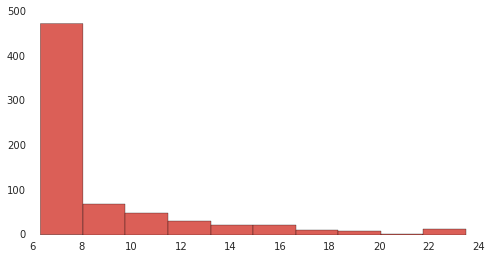

In [73]:
url_param = "http://twitter.com/footy_jokes/status/601331607371390976/photo/1"

time_list = activities_urls[activities_urls["expanded_url"]==url_param]["created_at"].tolist()

time_list = map(lambda s: time.strptime(s[:19], "%Y-%m-%d %H:%M:%S"), time_list)

numeric_time_list = map(lambda t: float(time.strftime("%H", t)) + float(time.strftime("%M", t))/60, time_list)
hour_list = map(lambda t: int(time.strftime("%H", t)), time_list)

plt.hist(numeric_time_list)
plt.show()
# sns.set_palette("hls")
# mpl.rc("figure", figsize=(8, 4))
# sns.distplot(hour_list);

### Alert type - Popular Tweet
* Engagement of tweet
* Potential of engagement

**popular_score** = engagement + potential


In [ ]:
# TODO